# Master's thesis code

**Sofia Morais - 152021001**

In [246]:
# Load the packages
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
import numpy as np
import pickle
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1. DATA PREPARATION

### 1.1 Creating the new dataset

In [171]:
# Import the original dataset and save it as "original"
original = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/original/original.xlsx', header=1,index_col=0)

# Data transformation
original.index.name='Timestamp'
original = original.rename(columns={'google': 'Popularity'})
original = original.rename(columns={'n-transactions-per-block': 'Total-circulating-BTC'}) # correct the name of one variable
original = original.rename(columns={'n-transactions-per-block.1': 'n-transactions-per-block'}) # correct the name of one variable
original.drop(original.columns[-21:], axis=1, inplace=True) # Delete the columns that you will not use
original.head() # Check the first observations

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-transactions-total,Popularity,Open,n-payments-per-block,Total-circulating-BTC,cost-per-transaction-percent,fees-usd-per-transaction,n-unique-addresses,n-transactions-per-block,output-volume
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,183961799.0,43,963.4,0.0,1808.982832,0.757827,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,183961799.0,74,995.4,0.0,1808.982832,0.726644,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,183961799.0,69,1017.0,0.0,1808.982832,0.718670,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,183961799.0,79,1033.3,0.0,1830.788898,0.668387,0.307901,488315.4,276578.033333,1.797751e+06
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,184884526.0,100,1135.4,0.0,1830.788898,0.705463,0.307901,488315.4,276578.033333,1.797751e+06


In [172]:
# Import the confidence index dataset and save it
confidence = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/consumer confidence index.csv',index_col='TIME')

# Data transformation
confidence= confidence[confidence["LOCATION"].str.contains("OECD")==True]
confidence= confidence[confidence["LOCATION"].str.contains("OECDE")==False]
confidence= confidence.drop(['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis='columns')

# Delete the the rows that you will not use
for i in confidence.index:
    if i>'2021-06':
        confidence=confidence.drop(i)
    continue

# Check the last values to make sure that you the previous code worked
confidence.head()

,Value
TIME,
2017-01,100.5115
2017-02,100.5401
2017-03,100.6480
2017-04,100.7638
2017-05,100.8411


In [173]:
# Create an empty column
original['Confidence']=''

# Add the confidence index variable to the original dataset
for i in original.index.strftime('%Y-%m'):
    for j in confidence.index:
        if i==j:
            original['Confidence'][i]=confidence['Value'][j]
    continue
original['Confidence'].head(32) #check the values between the first 2 months to guarantee that the values were  copied

<ipython-input-173-2a55fca83ce8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Confidence'][i]=confidence['Value'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    100.5115
2017-01-02    100.5115
2017-01-03    100.5115
2017-01-04    100.5115
2017-01-05    100.5115
2017-01-06    100.5115
2017-01-07    100.5115
2017-01-08    100.5115
2017-01-09    100.5115
2017-01-10    100.5115
2017-01-11    100.5115
2017-01-12    100.5115
2017-01-13    100.5115
2017-01-14    100.5115
2017-01-15    100.5115
2017-01-16    100.5115
2017-01-17    100.5115
2017-01-18    100.5115
2017-01-19    100.5115
2017-01-20    100.5115
2017-01-21    100.5115
2017-01-22    100.5115
2017-01-23    100.5115
2017-01-24    100.5115
2017-01-25    100.5115
2017-01-26    100.5115
2017-01-27    100.5115
2017-01-28    100.5115
2017-01-29    100.5115
2017-01-30    100.5115
2017-01-31    100.5115
2017-02-01    100.5401
Name: Confidence, dtype: object

In [174]:
# Import the variable gold save it
gold = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/gold.xlsx', header=4,index_col=1,sheet_name='Data')

# Create date and time with dataframe
data = pd.date_range('2014-01', periods = 104, freq ='M')

#Add to gold dataframe
gold.index=data

# Transform the data
gold.index=gold.index.strftime('%Y-%m')
gold.index.name='Timestamp'
gold= gold.drop(gold.columns[0], axis=1)
gold= gold.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in gold.index:
    if i<'2017-01' or i>'2021-06':
        gold=gold.drop(i)
    continue

gold.head()

,Price
Timestamp,
2017-01,1192.10
2017-02,1234.20
2017-03,1231.42
2017-04,1266.88
2017-05,1246.04


In [175]:
# Create an empty column
original['Gold']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in gold.index:
        if i==j:
            original['Gold'][i]=gold['Price'][j]
            
        continue
original['Gold'].head(32) #check the values between the first 2 months to guarantee that the values were copied

<ipython-input-175-312bbe7ac82a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Gold'][i]=gold['Price'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


KeyboardInterrupt: 

In [ ]:
# Import the binary variable of bitcoin regulation related news and save it
news_reg = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/news_regulation.xlsx', header=0,index_col=0)
news_reg.head()

# Add this variable to the original dataset
original['News Regulation'] = news_reg['news_regulation']
original.head(10) #check the original dataset

In [ ]:
## Sentiment analysis using Google Trends (GT)
# Import the variables
GT = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/GT.csv', header=1,index_col=0)

# Data transformation
GT = GT.rename(columns={'bitcoin legal: (Worldwide)': 'legal'})
GT = GT.rename(columns={'bitcoin cryptocurrency: (Worldwide)': 'cryptocurrency'})
GT = GT.rename(columns={'bitcoin scam: (Worldwide)': 'scam'})

# Delete the the rows that you will not use
for i in GT.index:
    if i>'2021-06-13':
        GT=GT.drop(i)
    continue
GT.head(300)

In [ ]:
# Add the Bitcoin+legal keyword variable to the original dataset
original['GT_legal']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_legal'][i] =GT['legal'][GT.index[j]]
        continue
        
original['GT_legal'].head() #check the original dataset

In [ ]:
#Convert string <1 in legal variable to a float
for j in range(len(original['GT_legal'])):
    if original['GT_legal'][j]=='<1':
        original['GT_legal'][j]=0.5
    continue

In [ ]:
# Add the Bitcoin+cryptocurrency keyword variable to the original dataset
original['GT_cryptocurrency']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_cryptocurrency'][i] =GT['cryptocurrency'][GT.index[j]]
        continue
original['GT_cryptocurrency'].head() #check the original dataset

In [ ]:
original['GT_scam']=''

# Add the Bitcoin+scam keyword variable to the original dataset
original['GT_scam']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_scam'][i] =GT['scam'][GT.index[j]]
        continue

original['GT_scam'].head() #check the original dataset

In [ ]:
## S&P500 index
# Import the variable
SP500 = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/SP500.csv', header=0,index_col=0)
SP500 = SP500.rename(columns={'s1': 'Value'})
SP500= SP500.drop(['conf','status1'], axis='columns')
SP500.index = pd.to_datetime(SP500.index)
SP500.index=SP500.index.strftime('%Y-%m')
SP500.head()

In [ ]:
original['SP500']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in SP500.index:
        if i==j:
            original['SP500'][i]=SP500['Value'][j]
            
        continue
original['SP500'].head(32) #check the values between the first 2 months to guarantee that the values were copied

In [ ]:
# Import the variable
oil = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/oil price.xlsx', sheet_name='Data',header=4,index_col=1)
oil=oil.drop(['Unnamed: 0'],axis='columns')
oil = oil.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in oil.index:
    if i<'2017' or i>'2021':
        oil=oil.drop(i)
    continue
oil.head()

In [ ]:
original['Oil']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in oil.index:
        if i==j:
            original['Oil'][i]=oil['Price'][j]
            
        continue
original['Oil'].head(366) #check the values between the first 2 years to guarantee that the values were copied

In [ ]:
theft = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/theft-2016-2020.xlsx', sheet_name='Data',header=4,index_col=1)
# Data Transformation of theft dataset
theft=theft.drop(['Unnamed: 0'],axis='columns')
theft = theft.rename(columns={'Unnamed: 2': 'Lost'})
theft.index = pd.to_datetime(theft.index,yearfirst=True, format= "%Y")
theft.index.name='Date'
theft.index=theft.index.strftime('%Y')
print(theft.head())

theft1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/theft-2020-2022.xlsx', sheet_name='Data',header=4,index_col=1)
# Data Transformation of theft1 dataset
theft1=theft1.drop(['Unnamed: 0','Recovered'],axis='columns')
theft1.index = pd.to_datetime(theft1.index)
theft1.index.name='Date'
theft1.index=theft1.index.strftime('%Y-%m')

# Delete the the rows that you will not use
for i in theft1.index:
    if i<='2020-12' or i>'2021-06':
        theft1=theft1.drop(i)
    continue
theft1.head()

In [ ]:
# Create an empty variable in the original dataset
original['Theft']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in theft.index:
        if i==j:
            original['Theft'][i]=theft['Lost'][j]
        continue
original['Theft'].head(366) #check the values between the first 2 years to guarantee that the values were copied

In [ ]:
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in theft1.index:
        if i==j:
            original['Theft'][i]=theft1['Lost'][j]
        continue

#check the values between the first 2 months of 2021 to guarantee that the values were copied
for i in original.index.strftime('%Y-%m-%d'):
    if i>'2021-01-01' and i<='2021-02-01':
        print(original['Theft'][i])

In [ ]:
# Export the final dataset to Excel
original.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx')

### 1.2 Cleaning the data

In [ ]:
# Reading the final dataset
final = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)
final.head() # check the pre-cleaned dataset

In [ ]:
# Check if there is any missing value in the dataset
check_nan = final.isnull().values.any()
print(check_nan)

## 2. DATA EXPLORATION

*Now we are able to extract the main information from the final dataset*

### 2.1 Descriptive Statistics

In [ ]:
final.describe().transpose()

*These table presents some information about the statistics of the variables, namely:*

*1. The difference between the mean and the median (50%) is quite significant in monetary and BTC variables. This might indicate that these variables are not normalised. Nevertheless, it is going to be checked below by plotting those distributions.*

*2. For example, average confirmation time has a maximum quite large in comparision with the median. Is it a outlier? It will be check that by plotting a histogram in the next steps.*

In [ ]:
# Plotting the Bitcoin price between 2017 and 2021
date = final['market-price'].index
value = final['market-price']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value);
plt.ylabel('Bitcoin price (USD)')
plt.title('Bitcoin price evolution')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/btc_price_years.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*Both plots show us that the BTC is the most volatile asset, comparing to Gold and S&P500.*

In [ ]:
plt.hist(final['market-price'],edgecolor='black', linewidth=1.2)
plt.title('Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_marketprice.jpg') # save this figure to use in the thesis
plt.show()

*As we can see, the BTC price is clearly skewed to the right. This means that we should apply log transformation to the variable.*

In [ ]:
# Creating a new dataframe to model
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)

# Applying log transformation into price-variables
model['market-price']=np.log(model['market-price'])
model['market-cap']=np.log(model['market-cap'])
model['High']=np.log(model['High'])
model['Low']=np.log(model['Low'])
model['Open']=np.log(model['Open'])
model['cost-per-transaction-percent']=np.log(model['cost-per-transaction-percent'])
model['fees-usd-per-transaction']=np.log(model['fees-usd-per-transaction'])
model['transaction-fees-usd']=np.log(model['transaction-fees-usd'])

# Rename the log variables
model = model.rename(columns={'market-price': 'lg_price'})
model = model.rename(columns={'market-cap': 'lg_market-cap'})
model = model.rename(columns={'High': 'lg_High'})
model = model.rename(columns={'cost-per-transaction-percent': 'lg_cost-per-transaction-percent'})
model = model.rename(columns={'Open': 'lg_Open'})
model = model.rename(columns={'Low': 'lg_Low'})
model = model.rename(columns={'fees-usd-per-transaction': 'lg_fees-usd-per-transaction'})
model = model.rename(columns={'transaction-fees-usd': 'lg_transaction-fees-usd'})

# Visualize the new transformation
plt.hist(model['lg_price'],edgecolor='black', linewidth=1.2, color='orange')
plt.title('Logarithm of Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_logprice.jpg') # save this figure to use in the thesis
plt.show()

*Now we have a Normal Distribution as intended.*

*Next, we are going to investigate the same issue for some explanatory variables where we may need to apply the same solution.*

In [ ]:
# Check the distributions and outliers of teh other variables
#Plot 1 - Trade Volume
plt.subplot(4,4,1)
plt.hist(model['trade-volume'],edgecolor='black', linewidth=1.2)
plt.title('1')

#Plot 2 - Average Confirmation Time
plt.subplot(4,4,2)
plt.hist(model['avg-confirmation-time'],edgecolor='black', linewidth=1.2)
plt.title('2')

#Plot 2 - difficulty
plt.subplot(4,4,3)
plt.hist(model['difficulty'],edgecolor='black', linewidth=1.2)
plt.title('3')

#Plot 4 - Hash rate
plt.subplot(4,4,4)
plt.hist(model['hash-rate'],edgecolor='black', linewidth=1.2)
plt.title('4')

#Plot 5 - block size
plt.subplot(4,4,5)
plt.hist(model['block-size'],edgecolor='black', linewidth=1.2)
plt.title('5')

#Plot 6 - total of transactions
plt.subplot(4,4,6)
plt.hist(model['n-transactions-total'],edgecolor='black', linewidth=1.2)
plt.title('6')

#Plot 7 - number of payments per block
plt.subplot(4,4,7)
plt.hist(model['n-payments-per-block'],edgecolor='black', linewidth=1.2)
plt.title('7')
          
#Plot 8 - block size
plt.subplot(4,4,8)
plt.hist(model['block-size'],edgecolor='black', linewidth=1.2)
plt.title('8')
          
#Plot 9 - Total of BTC circulating
plt.subplot(4,4,9)
plt.hist(model['Total-circulating-BTC'],edgecolor='black', linewidth=1.2)
plt.title('9')
          
#Plot 10 - number of unique addresses
plt.subplot(4,4,10)
plt.hist(model['n-unique-addresses'],edgecolor='black', linewidth=1.2)
plt.title('10')
          
#Plot 11 - number of transactions per block
plt.subplot(4,4,11)
plt.hist(model['n-transactions-per-block'],edgecolor='black', linewidth=1.2)
plt.title('11')
          
#Plot 12 - output volume
plt.subplot(4,4,12)
plt.hist(model['output-volume'],edgecolor='black', linewidth=1.2)
plt.title('12')
          
#Plot 13 - Gold
plt.subplot(4,4,13)
plt.hist(model['Gold'],edgecolor='black', linewidth=1.2)
plt.title('13')

#Plot 14 - S&P500
plt.subplot(4,4,14)
plt.hist(model['SP500'],edgecolor='black', linewidth=1.2)
plt.title('14')
          
#Plot 15 - Oil
plt.subplot(4,4,15)
plt.hist(model['Oil'],edgecolor='black', linewidth=1.2)
plt.title('15')
          
#Plot 16 - Theft
plt.subplot(4,4,16)
plt.hist(model['Theft'],edgecolor='black', linewidth=1.2)
plt.title('16')

*The plots number 1,2,3,4,9,10,12,13,14 are skewed. Thefore,it seems reasonable to use log transformation for all these plots.In the other situations, the log transformation does not make the desired improvements. Consequently, it will not be applied for those cases.*

In [ ]:
# Log transformation
model['trade-volume']=np.log(model['trade-volume'])
model['avg-confirmation-time']=np.log(model['avg-confirmation-time'])
model['difficulty']=np.log(model['difficulty'])
model['hash-rate']=np.log(model['hash-rate'])
model['Total-circulating-BTC']=np.log(model['Total-circulating-BTC'])
model['n-unique-addresses']=np.log(model['n-unique-addresses'])
model['output-volume']=np.log(model['output-volume'])
model['Gold']=np.log(model['Gold'])
model['SP500']=np.log(model['SP500'])

# Rename the variables
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'avg-confirmation-time': 'lg_avg-confirmation-time'})
model = model.rename(columns={'difficulty': 'lg_difficulty'})
model = model.rename(columns={'hash-rate': 'lg_hash-rate'})
model = model.rename(columns={'Total-circulating-BTC': 'lg_circulatingBTC'})
model = model.rename(columns={'n-unique-adresses': 'lg_n-unique-adresses'})
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'output-volume': 'lg_output-volume'})
model = model.rename(columns={'Gold': 'lg_Gold'})
model = model.rename(columns={'SP500': 'lg_SP500'})

In [ ]:
# Export the dataset to Excelthat will be used to modelling
model.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx')

In [ ]:
# Plotting the the log of Bitcoin price vs the log of Gold price between 2017 and 2021
date = model['lg_price'].index
value = model['lg_price']
value1 = model['lg_Gold']
value2 = model['lg_SP500']
fig, ax = plt.subplots(figsize=(4, 3))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,value1);
plt.title('The evolution of the log of Bitcoin price and the log of Gold price')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsGold.jpg') # save this figure to use in the thesis

# Plotting the log of Bitcoin price vs the log of SP500 price between 2017 and 2021
fig, ax = plt.subplots(figsize=(4, 3))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='purple')
ax.plot(date, value2,color='yellow')
plt.title('The evolution of the log of Bitcoin price and the log of S&P500 index')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsSP500.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

In [ ]:
# PLot number of transactions of BTC over time
date = final['n-transactions-total'].index
value = final['n-transactions-total']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='orange');
plt.title('The evolution of the number of transactions')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/n_transactions.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*This plot shows that there is clearly a peak in 2020 on the number of BTC transactions and since then the variable is still decreasing.*

In [ ]:
# Finding which keyword associated with Bitcoin that is more frequent in Google Trends
# Bitcoin+legal - POSITIVE SENTIMENT
plt.subplot(1,3,1)
sns.boxplot(y='GT_legal',data=model,color='orange')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('legal')

# Bitcoin+cryptocurrency - NEUTRAL SENTIMENT
plt.subplot(1,3,2)
sns.boxplot(y='GT_cryptocurrency',data=model)
plt.ylim(1, 26)
plt.ylabel('')
plt.title('cryptocurrency')

# Bitcoin+scam - NEGATIVE SENTIMENT
plt.subplot(1,3,3)
sns.boxplot(y='GT_scam',data=model, color='yellow')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('scam')

# Save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/GT_boxplots.jpg') 

*It seems that, on average, the neutral sentiment regarding Bitcoin is the more predominat, comparing to the positive sentiment and the negative sentiment expressed through Google searches.*

In [ ]:
model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlOrBr")
heatmap.set_title('Features Correlating with the log of Bitcoin Price', fontdict={'fontsize':18}, pad=16);
# save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/wr_corr_heatmap.png') 

*Most important conclusions obtained from this correlations heatmap:*

*1. The log of SP500 presents the highest correlation in the log of BTC price and it is not a transactions-based variable.*

*2. Although "legal" is not the most frequent Google Trend keyword, comparing to the other two, it is the most correlated one with BTC price. Note that this keyword represents a positive sentiment regarding Bitcoin.*

*3. An interesting fact is that when consumers' confidence index increases, which reflects a positive sentiment about the general economic situation, unemployment and capability of savings, the log of BTC price decreases. In this case, will they demand substitute assets of BTC?*

*4. There are transaction-based variables that are not highly correlated with the log of BTC price, as it had been expected, namely the log of market capitalisation.*

### 2.2 - Time series

In [41]:
f = Forecaster(y=model['lg_price'],
                   current_dates=model.index)
f

Forecaster(
    DateStartActuals=2017-01-01T00:00:00.000000000
    DateEndActuals=2021-06-04T00:00:00.000000000
    Freq=None
    N_actuals=1615
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

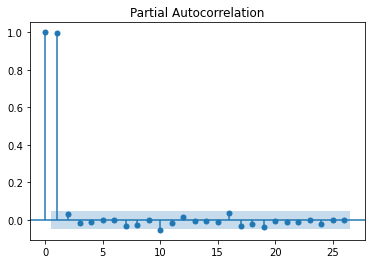

In [42]:
f.plot_pacf(lags=26)
plt.show()

*It was decomposed this time series by viewing the PACF (Partial Auto Correlation Function) plot, which measures how much the y variable (lg_price) is correlated to past values of itself and how far back a statistically significant correlation exists. The PACF plot is different from the ACF plot in that PACF controls for correlation between past terms. It is good to view both, but only PACF will be displayed here.*

*This plot indicates a statistically significant correlation may exist up to two years in the data. That will be good information to use when modeling. Let’s further decompose the series into its trend, seasonal, and residual parts:*

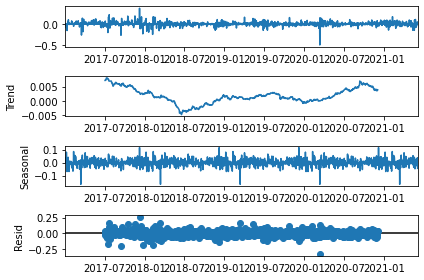

In [134]:
f.seasonal_decompose(period=365).plot()
plt.show()

*Firstly, the second plot shows a a growing trend, but it is not linear.*

*Secondly, the next graph indicates the existence of seasonality in this data.*

*FInally, the residuals does not present a pattern.*

In [44]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat,pval)

-1.3456970510343018 0.608015394647876


*In this case, the trend is pretty clearly non-stationary as it is increasing upward year-after-year. In addition, the results of the Augmented Dickey-Fuller (ACF) test give statistical justification to what our eyes see. Since the p-value is not less than 0.05, we must assume the series is non-stationary.*

## 3. MODELLING

In [27]:
# Reading the model dataset
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

#Check the first observations
model.head()

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_Low,lg_hash-rate,block-size,...,lg_output-volume,Confidence,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,lg_SP500,Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,26.484337,6.921086,6.862863,14.767149,97293.875547,...,14.342027,100.5115,7.083472,0,1.0,2,1,7.729786,52.51,266.0
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,26.484337,6.938963,6.897907,14.767149,97293.875547,...,14.342027,100.5115,7.083472,0,1.0,2,1,7.729786,52.51,266.0
2017-01-03,6.921086,23.527405,15.376856,11.651582,2.799824,26.484337,6.942640,6.914234,14.767149,97293.875547,...,14.342027,100.5115,7.083472,0,1.0,2,1,7.729786,52.51,266.0
2017-01-04,6.907405,23.590040,15.583291,11.651582,3.614366,26.484337,7.046212,6.907405,14.748687,97743.656720,...,14.402047,100.5115,7.083472,0,1.0,2,1,7.729786,52.51,266.0
2017-01-05,6.907405,23.590040,15.583291,11.711432,2.841877,26.484337,7.048039,6.773652,14.579937,97743.656720,...,14.402047,100.5115,7.083472,0,1.0,2,1,7.729786,52.51,266.0


### 3.1 Linear regression

**3.1.1 - Model formulation**

In [28]:
# Check the dimentions of the model dataset
print(model.shape)

(1615, 30)


In [29]:
# define the data/predictors as the pre-set feature names  
X=model.iloc[:,1:31]

# Put the target (lg_price) in another DataFrame
target = model["lg_price"]

In [5]:
# Define the variables
y = target ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# fit a model
lm = linear_model.LinearRegression()
fit = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

(1292, 30) (1292,)
(323, 30) (323,)


In [6]:
predictions[0:5]

array([ 7.10401931, 10.82735255,  9.33477236,  8.79408494, 10.81209741])

Text(0, 0.5, 'Predictions')

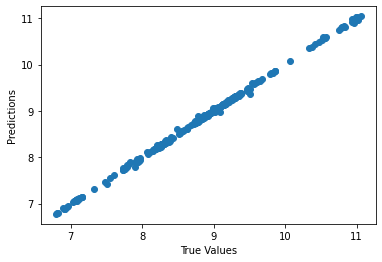

In [7]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [8]:
#Printing the score
print('Score: ', fit.score(X_test, y_test))

Score:  0.9992338049903796


*The limitation of train/test split is if, by chance, the split made was not random.* 

*This will result in overfitting, even though it was tried to avoid it. Therefore, it is introduced cross validation.*

In [9]:
# Cross Validation
kf = KFold(n_splits=2, random_state=None, shuffle=False) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

scores = cross_val_score(fit, X, y, cv=6)
print('Cross-validated scores:', scores)

KFold(n_splits=2, random_state=None, shuffle=False)
Cross-validated scores: [0.99440955 0.97983015 0.99861336 0.99861204 0.99433163 0.99495779]


In [10]:
# Getting the coefficients of the linear regression
pd.DataFrame(lm.coef_, 
             X.columns, 
             columns=['coefficient'])\
            .sort_values(by='coefficient', ascending=False)

,coefficient
const,8.208659e+02
lg_Open,6.204161e-01
lg_Low,1.907514e-01
lg_High,1.737175e-01
lg_Gold,2.682499e-02
lg_transaction-fees-usd,1.452432e-02
News Regulation,8.982242e-03
lg_market-cap,8.839721e-03
lg_trade-volume,1.291998e-03
GT_scam,1.080469e-03


**3.1.2. - Evaluation metrics**

In [11]:
# 1. MSE - Mean Squared Error
MSE = np.square(np.subtract(y_test,predictions)).mean() 
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
sMAPE=smape(y_test,predictions)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(y_test, predictions)
print('R^2 score: ',r2_score)

Mean Square Error:  0.0005746332921705514
Root Mean Square Error:  0.02397151001022988
sMAPE:  0.15874112565511508
R^2 score:  0.9992338049903796


### 3.2 - LSTM

In [117]:
# Reading the model dataset
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data preparation:

In [158]:
# Splitting 80% for training and 20% for testing
x_train = model1[:-323]
len(train)
x_test = model1[-323:]
len(test)
train_dates = train.index
test_dates  = test.index

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

prediction_days = 323
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['lg_price'].values.reshape(-1,1))

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

1292 train sequences
323 test sequences


* Build the model

In [159]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train, epochs = 25, batch_size=32, validation_split=0.2)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 323, 128)          66560     
                                                                 
 dropout_48 (Dropout)        (None, 323, 128)          0         
                                                                 
 lstm_59 (LSTM)              (None, 323, 128)          131584    
                                                                 
 dropout_49 (Dropout)        (None, 323, 128)          0         
                                                                 
 lstm_60 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 1)               

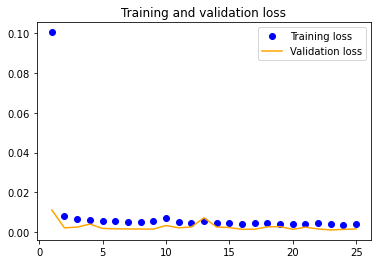

In [172]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(1,26)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*The plot shows that the training operation becomes stable after the second epoch time.*

* Prediction

In [175]:
actual_price = test['lg_price'].values
total_price = pd.concat((train['lg_price'], test['lg_price']),axis=0)

model_inputs = total_price[len(total_price)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predicting the values for lg_price
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense

[[9.054631]
 [9.055218]
 [9.055434]
 [9.055318]
 [9.05496 ]]


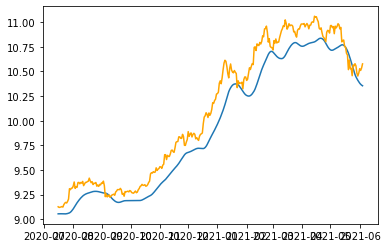

In [277]:
original_test=model1.iloc[-323:,0]
plt.plot(test.index, pred, label='Predicted')
plt.plot(test.index, original_test, label='Real',color='orange')

*Therefore, in this case, LSTM leads to slightly undervalued predictions.*

In [176]:
# 1. MSE - Mean Squared Error
MSE2 = np.square(np.subtract(actual_temp,pred)).mean() 
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE2 = math.sqrt(MSE2)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
sMAPE2=smape(actual_temp,pred)
print('sMAPE: ',sMAPE2)

# 4. R^2 score
r2_score2 = metrics.r2_score(actual_temp,pred)
print('R^2 score: ',r2_score2)

Mean Square Error:  0.0005746332921705514
Root Mean Square Error:  0.02397151001022988
sMAPE:  2460.6545727679904
R^2 score:  0.9178999316746457


In [177]:
# Defining a dictionary
d = {'Model': ['Linear Regression','LSTM'],'MSE': [MSE,MSE2],'RMSE':[RMSE,RMSE2],'sMAPE':[sMAPE,sMAPE2],'R^2 score': [r2_score,r2_score2]}

# Creating a dataframe to compare the evaluation metrics results of the 2 models
pd.DataFrame(d, index=[0,1])

,Model,MSE,RMSE,sMAPE,R^2 score
0,Linear Regression,0.000575,0.023972,0.158741,0.999234
1,LSTM,0.894677,0.945874,2460.654573,0.917900


### 3.3 - SHAP applied on LSTM

**(A) Variable Importance Plot — Global Interpretability**

In [281]:
# SHAP model explainer
explainer = shap.DeepExplainer(model, x_train)
shap_value = explainer.shap_values(x_test)
shap_val = np.array(shap_value)

AttributeError: 'tuple' object has no attribute 'shape'

In [278]:
explainer = shap.explainers.Permutation(model, x_train,max_evals = 647)
shap_values = explainer(x_test)

TypeError: 'numpy.ndarray' object is not callable